Load packages

In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_for_CAR_annotation as ca

/tmp/ipykernel_3427577/1078855118.py:19: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [71]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(ca)

<module 'functions_for_CAR_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_for_CAR_annotation.py'>

Import data

In [5]:
adata_raw = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_pools_prior_any_processing.h5ad') #prior to any sort of processing, shows maximal possible yield with respect to CAR-T annotation
adata_dLN = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_calagry_exact_TIL_only.h5ad') #after dLN filtering
adata_pureTC = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_pureTCs_calagry_exact.h5ad') #after annotating pureTCs and prior to anotating TC subtypes
adata_pure_TC_and_rest = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_calagry_exact_TIL_only_celltypes.h5ad') #after annotating pureTCs and prior to anotating TC subtypes
adata_annotated = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_calagry_exact.h5ad') #after annotating TCs and TC subtypes

# differently processed datasets
# adata = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_pseudocount.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_abs_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_soupx_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/HTODemux_abs_1000_nosoup.h5ad')

In [11]:
for adata in [adata_raw, adata_dLN, adata_pure_TC_and_rest, adata_pureTC, adata_annotated]:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

In [12]:
#only needed for adata_annotated, since it still contains NAs for TC subtypes
nas = adata_annotated.obs.Tcell_subtype == "NA"
adata_annotated_nona = adata_annotated[~nas,:].copy()

In [14]:
path = './01_data/processed/count_cart_receptor'
VDJ_GEX_list = ca.read_and_merge_CAR_annotation(path) #list with dims: list[1][8]
merged = [ca.merge_VDJ_and_GEX(GEX, VDJ) for (GEX, VDJ) in zip(*VDJ_GEX_list)]

annotated = []
for adata in [adata_raw, adata_dLN, adata_pure_TC_and_rest, adata_pureTC, adata_annotated_nona]:
    new_adata = ca.annotate_mapped_cars(adata, merged)
    annotated.append(new_adata)

In [15]:
car_genes = ['CD19_trunc', 'R11_ScFV']
for adata in annotated:
    adata.obs[car_genes] = adata.obs[car_genes].fillna(0)

In [26]:
#check what celltypes CAR TCR containing cells are assigned to if not pure TCs
car_and_celltypes_annotated = annotated[2]
only_car = ca.isCAR(car_and_celltypes_annotated)
only_car_nonTCs = only_car[only_car.obs['is.pure_Tcell'] == 'Impure']

In [27]:
#see that cells not assigned as pureTCs that have reads matching the CD19 CAR-T marker are not assigned to any cell type at all (probably due to lacking marker genes)
only_car_nonTCs.obs.scGate_multi.unique()

[NaN]
Categories (0, object): []

In [29]:
#for raw (theoretical maximum of annotated CAR-Ts)
only_cars_raw_adata = ca.isCAR(annotated[0])
cars_beginning = only_cars_raw_adata.obs.groupby('dataset').size()
cars_beginning

dataset
0    5169
1      24
2      12
3      13
4      11
5       3
6      15
7      10
8       4
dtype: int64

In [30]:
#for only TILs after qc and demultiplexing
only_cars_qc_adata = ca.isCAR(annotated[1])
cars_qc = only_cars_qc_adata.obs.groupby('dataset').size()

pools = range(0,9)
cars_qc = cars_qc.reindex(pools, fill_value=0)
cars_qc

dataset
0    1177
1       4
2       8
3       0
4       3
5       0
6      10
7       0
8       1
dtype: int64

In [31]:
#whats lost due to demultiplexing, qc and eliminating dLNs
(cars_beginning - cars_qc) / cars_beginning *100

dataset
0     77.229638
1     83.333333
2     33.333333
3    100.000000
4     72.727273
5    100.000000
6     33.333333
7    100.000000
8     75.000000
dtype: float64

In [32]:
#for after annotation
only_cars_pure_tc_adata = ca.isCAR(annotated[3])
cars_tcan = only_cars_pure_tc_adata.obs.groupby('dataset').size()

cars_tcan = cars_tcan.reindex(pools, fill_value=0)
cars_tcan

dataset
0    1176
1       1
2       0
3       0
4       1
5       0
6       1
7       0
8       0
dtype: int64

In [197]:
#whats lost due to annotating celltypes with scGate
(cars_qc - cars_tcan) / cars_beginning *100

dataset
0     0.019346
1    12.500000
2    66.666667
3     0.000000
4    18.181818
5     0.000000
6    60.000000
7     0.000000
8    25.000000
dtype: float64

In [33]:
#for after annotation
only_annotated_cars_adata = ca.isCAR(annotated[4])
end_cars = only_annotated_cars_adata.obs.groupby('dataset').size()
end_cars = end_cars.reindex(pools, fill_value=0)
end_cars

dataset
0    961
1      1
2      0
3      0
4      0
5      0
6      1
7      0
8      0
dtype: int64

In [34]:
#awnser question as to how many carTs are detected as CAR-Ts in the course of the experiment with respect to pool1, since those cells should all be cart cells
number_cells_after_qc = annotated[1][annotated[1].obs.dataset == 0].shape[0]
number_CAR_after_qc = cars_qc[0]
number_CAR_after_qc / number_cells_after_qc

0.7301488833746899

In [36]:
#we know how many carT cells are in pool 1 (100% or nearly)
#so asuuming after qc only real cells remain, how many of these real carT cells are actually correctly identified as CART cells?

number_CAR_tcpure= cars_tcan[0]
number_CAR_tcpure / number_cells_after_qc

0.7295285359801489

In [35]:
#we know how many carT cells are in pool 1 (100% or nearly)
#so asuuming after qc only real cells remain, how many of these real carT cells are actually correctly identified as CART cells?

number_CAR_end= end_cars[0]
number_CAR_end / number_cells_after_qc

0.5961538461538461

In [59]:
np.array(datasets) + 1

array([2, 3, 4, 5, 6, 7, 8, 9])

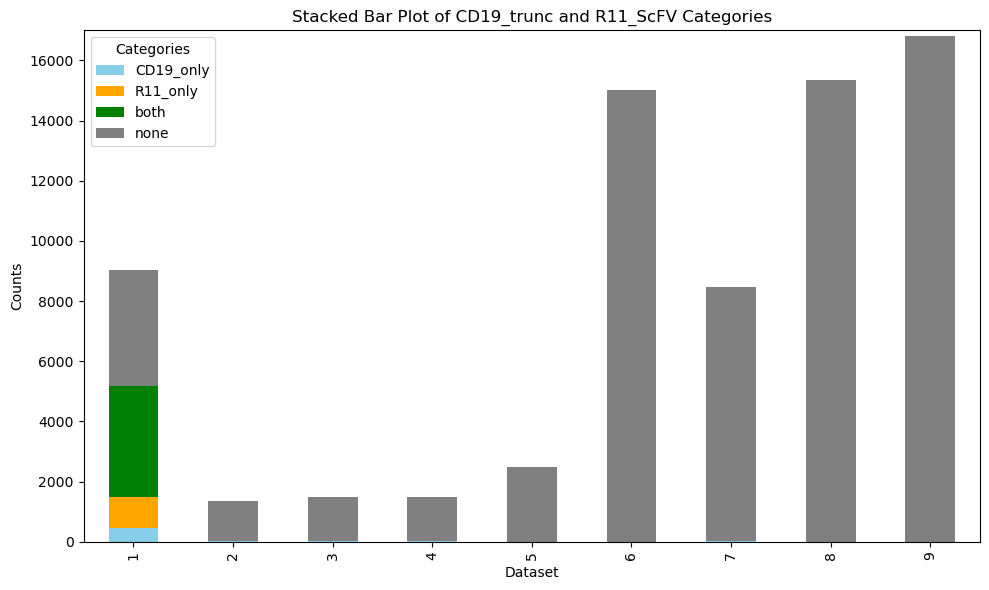

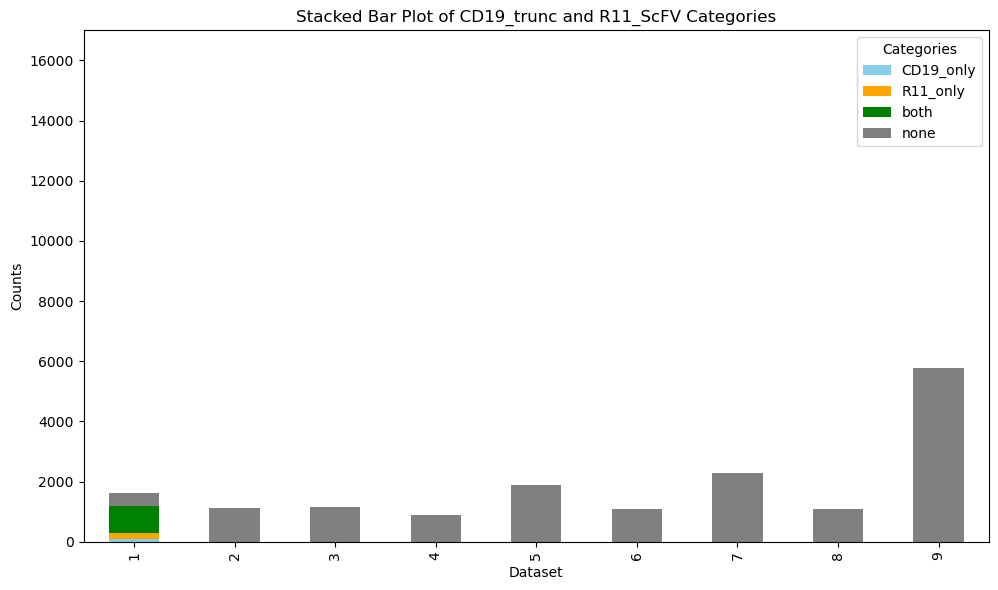

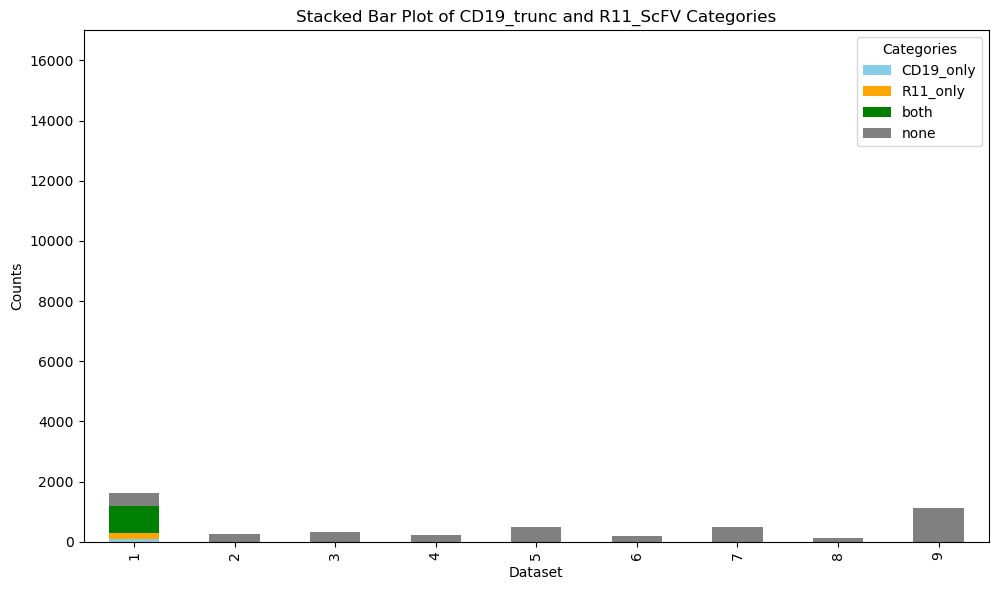

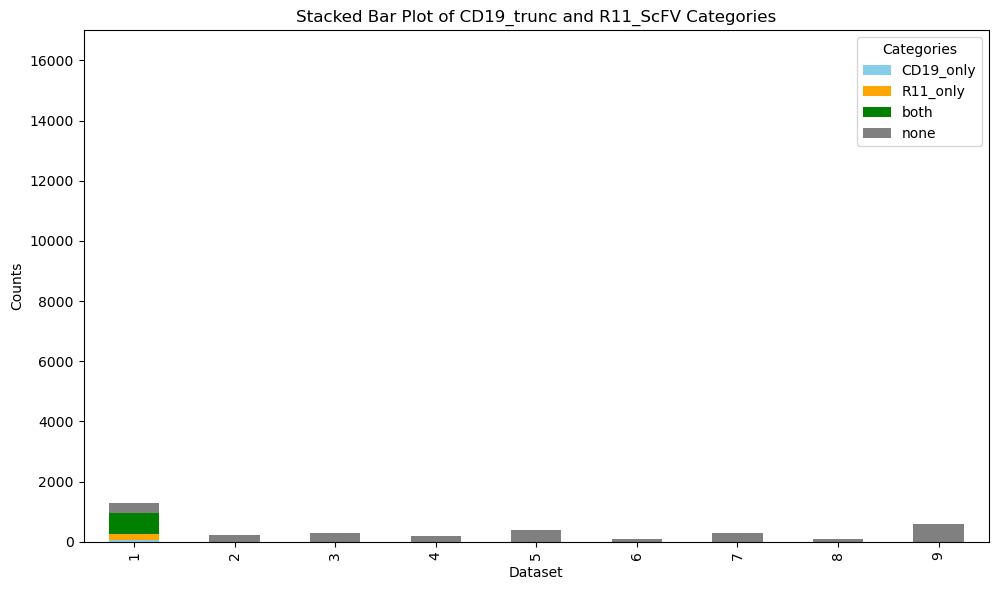

In [73]:
for i,adata in enumerate(annotated):
    if i == 2:
        continue
    datasets = np.unique(adata.obs.dataset)

    # Calculate the categories
    categories_df = ca.calculate_categories(adata.obs, datasets)

    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    plt.title('Stacked Bar Plot of CD19_trunc and R11_ScFV Categories')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 17000)
    plt.show()

In [77]:
categories_df.drop(columns=['none'], inplace=True)

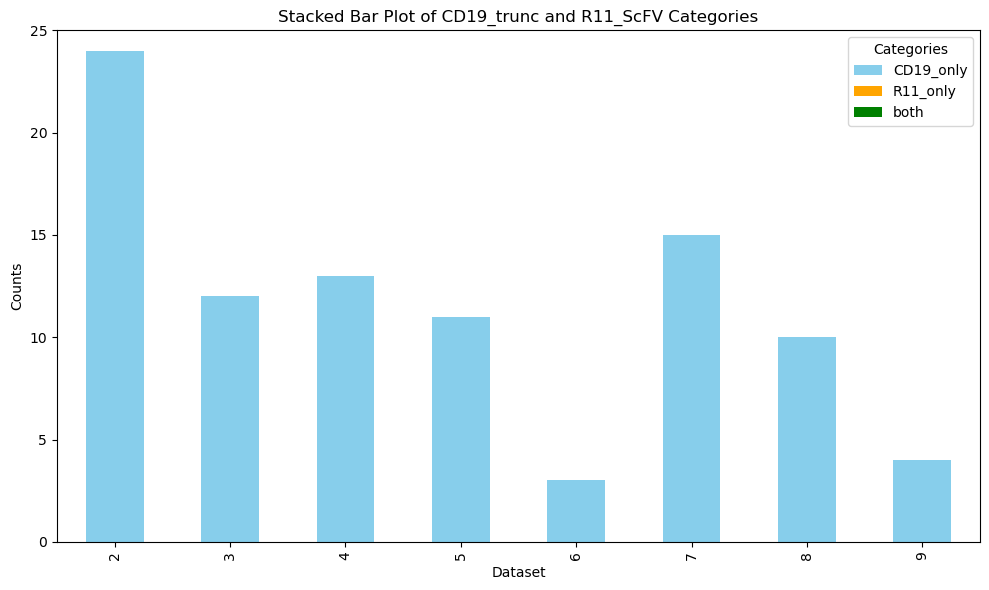

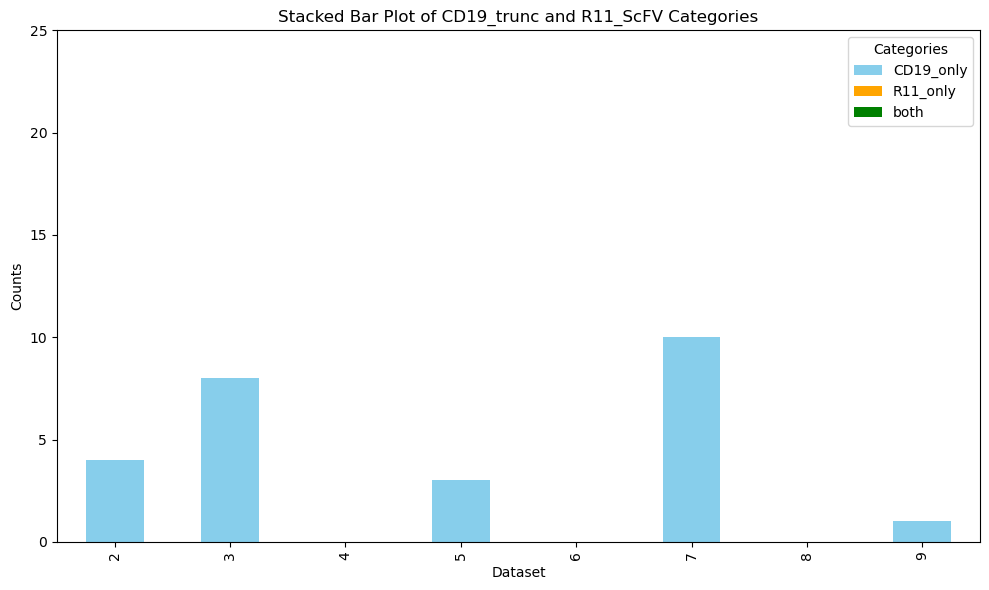

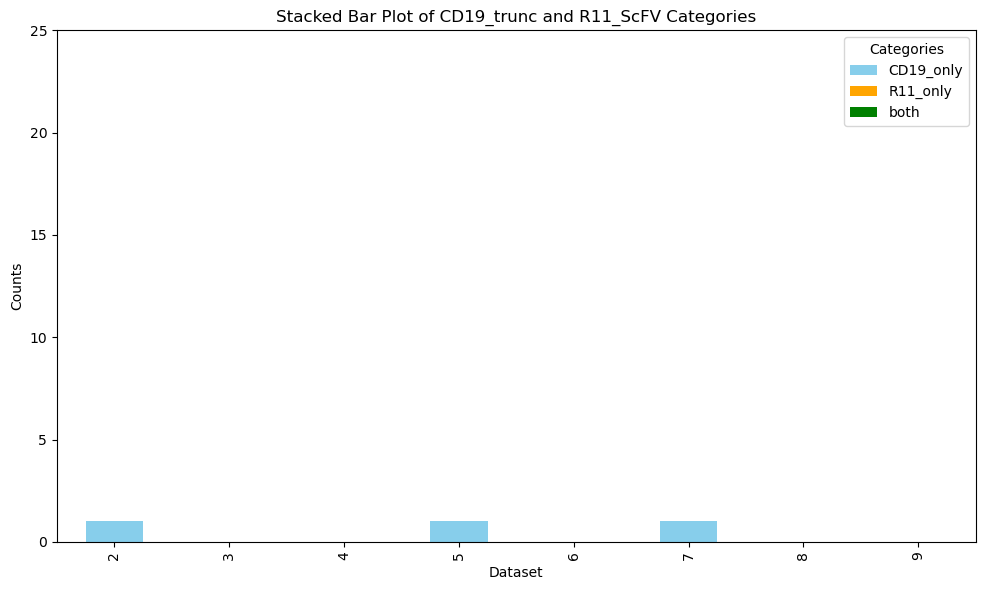

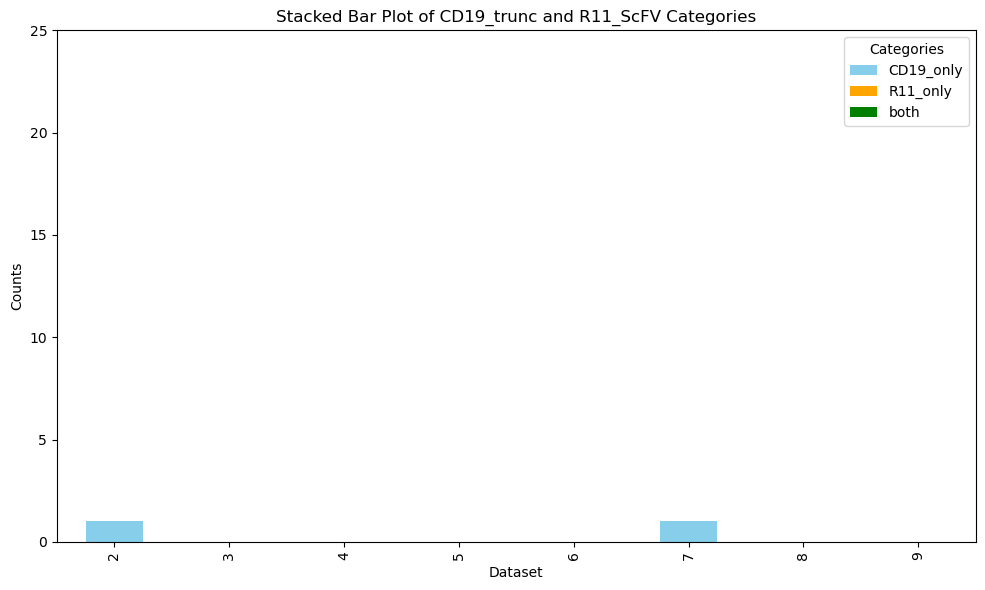

In [78]:
for i,adata in enumerate(annotated):
    if i == 2:
        continue
    datasets = np.unique(adata.obs.dataset)
    datasets = list(filter(lambda x: x != 0, datasets))

    # Calculate the categories
    categories_df = ca.calculate_categories(adata.obs, datasets)
    categories_df.drop(columns=['none'], inplace=True)
    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    plt.title('Stacked Bar Plot of CD19_trunc and R11_ScFV Categories')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 25)
    plt.show()